Hyperparameters:
{
  "N_u": 2000,
  "layers": [
    2,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    20,
    1
  ],
  "tf_epochs": 100,
  "tf_lr": 0.001,
  "tf_b1": 0.9,
  "tf_eps": null,
  "nt_epochs": 500,
  "nt_lr": 0.8,
  "nt_ncorr": 50,
  "log_frequency": 10
}

TensorFlow version: 2.3.0
Eager execution: True
GPU-accerelated: False

Training started
-- Starting Adam optimization --
tf_epoch =      0  elapsed = 00:00 (+00.1)  loss = 3.0386e-01  
tf_epoch =     10  elapsed = 00:00 (+00.7)  loss = 2.2977e-01  
tf_epoch =     20  elapsed = 00:01 (+00.7)  loss = 2.0751e-01  
tf_epoch =     30  elapsed = 00:02 (+00.7)  loss = 1.6048e-01  
tf_epoch =     40  elapsed = 00:03 (+00.7)  loss = 1.0116e-01  
tf_epoch =     50  elapsed = 00:03 (+00.6)  loss = 6.3302e-02  
tf_epoch =     60  elapsed = 00:04 (+00.7)  loss = 4.5773e-02  
tf_epoch =     70  elapsed = 00:05 (+00.7)  loss = 3.9030e-02  
tf_epoch =     80  elapsed = 00:05 (+00.7)  loss = 3.4828e-02  
tf_epoch =     90  el

nt_epoch =    440  elapsed = 01:38 (+00.9)  loss = 2.8104e-03  
nt_epoch =    450  elapsed = 01:39 (+00.9)  loss = 2.6747e-03  
nt_epoch =    460  elapsed = 01:40 (+00.9)  loss = 2.5194e-03  
nt_epoch =    470  elapsed = 01:41 (+00.9)  loss = 2.4251e-03  
nt_epoch =    480  elapsed = 01:42 (+00.9)  loss = 2.3087e-03  
nt_epoch =    490  elapsed = 01:43 (+01.0)  loss = 2.2172e-03  
Training finished (epoch 600): duration = 01:44  error = 3.9475e-01  
l1:  0.9621243509943183
l2:  0.005398560370829753
l1_noise:  0.9154278985245292
l2_noise:  0.005426950150970503


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


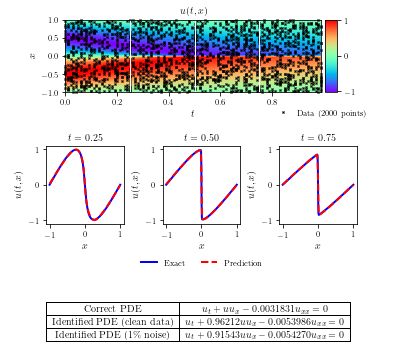

In [5]:
import sys
import os
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import json

# Manually making sure the numpy random seeds are "the same" on all devices
np.random.seed(1234)
tf.random.set_seed(1234)

#%% LOCAL IMPORTS

eqnPath = "1d-burgers"
sys.path.append(eqnPath)
sys.path.append("utils")
from burgersutil import prep_data, plot_ide_cont_results
from neuralnetwork import NeuralNetwork
from logger import Logger

#%% HYPER PARAMETERS

if len(sys.argv) < 1:
    with open(sys.argv[1]) as hpFile:
        hp = json.load(hpFile)
else:
    hp = {}
    # Data size on the solution u
    hp["N_u"] = 2000
    # DeepNN topology (2-sized input [x t], 8 hidden layer of 20-width, 1-sized output [u]
    hp["layers"] = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
    # Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
    hp["tf_epochs"] = 100
    hp["tf_lr"] = 0.001
    hp["tf_b1"] = 0.9
    hp["tf_eps"] = None
    # Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
    hp["nt_epochs"] = 500
    hp["nt_lr"] = 0.8
    hp["nt_ncorr"] = 50
    hp["log_frequency"] = 10

class BurgersInformedNN(NeuralNetwork):
    def __init__(self, hp, logger, ub, lb):
        super().__init__(hp, logger, ub, lb)

        # Defining the two additional trainable variables for identification
        self.lambda_1 = tf.Variable([0.0], dtype=self.dtype)
        self.lambda_2 = tf.Variable([-6.0], dtype=self.dtype)

    # The actual PINN
    def f_model(self, X_u):
        l1, l2 = self.get_params()
    # Separating the collocation coordinates
        x_f = tf.convert_to_tensor(X_u[:, 0:1], dtype=self.dtype)
        t_f = tf.convert_to_tensor(X_u[:, 1:2], dtype=self.dtype)

    # Using the new GradientTape paradigm of TF2.0,
    # which keeps track of operations to get the gradient at runtime
        with tf.GradientTape(persistent=True) as tape:
        # Watching the two inputs we’ll need later, x and t
            tape.watch(x_f)
            tape.watch(t_f)
      # Packing together the inputs
            X_f = tf.stack([x_f[:,0], t_f[:,0]], axis=1)


      # Getting the prediction
            u = self.model(X_f)
      # Deriving INSIDE the tape (since we’ll need the x derivative of this later, u_xx)
            u_x = tape.gradient(u, x_f)

    # Getting the other derivatives
        u_xx = tape.gradient(u_x, x_f)
        u_t = tape.gradient(u, t_f)

    # Letting the tape go
        del tape

    # Buidling the PINNs
        return u_t + l1*u*u_x - l2*u_xx

    # Defining custom loss
    def loss(self, u, u_pred):
        f_pred = self.f_model(self.X_u)
        return tf.reduce_mean(tf.square(u - u_pred)) + \
            tf.reduce_mean(tf.square(f_pred))

    def wrap_training_variables(self):
        var = self.model.trainable_variables
        var.extend([self.lambda_1, self.lambda_2])
        return var

    def get_weights(self):
        w = super().get_weights(convert_to_tensor=False)
        w.extend(self.lambda_1.numpy())
        w.extend(self.lambda_2.numpy())
        return tf.convert_to_tensor(w, dtype=self.dtype)

    def set_weights(self, w):
        super().set_weights(w)
        self.lambda_1.assign([w[-2]])
        self.lambda_2.assign([w[-1]])

    def get_params(self, numpy=False):
        l1 = self.lambda_1
        l2 = tf.exp(self.lambda_2)
        if numpy:
            return l1.numpy()[0], l2.numpy()[0]
        else:
            return l1, l2

    def fit(self, X_u, u):
        self.X_u =  tf.convert_to_tensor(X_u, dtype=self.dtype)
        super().fit(X_u, u)
    def predict(self, X_star):
        u_star = self.model(X_star)
        f_star = self.f_model(X_star)
        return u_star.numpy(), f_star.numpy()

# Getting the data
path = os.path.join("data", "burgers_shock.mat")
x, t, X, T, Exact_u, X_star, u_star, \
        X_u_train, u_train, ub, lb = prep_data(path, hp["N_u"], noise=0.0)
lambdas_star = (1.0, 0.01/np.pi)

# Creating the model
logger = Logger(hp)
pinn = BurgersInformedNN(hp, logger, ub, lb)

# Defining the error function and training
def error():
    l1, l2 = pinn.get_params(numpy=True)
    l1_star, l2_star = lambdas_star
    error_lambda_1 = np.abs(l1 - l1_star) / l1_star
    error_lambda_2 = np.abs(l2 - l2_star) / l2_star
    return (error_lambda_1 + error_lambda_2) / 2

logger.set_error_fn(error)
pinn.fit(X_u_train, u_train)

# Getting the model predictions, from the same (x,t) that the predictions were previously gotten from
u_pred, f_pred = pinn.predict(X_star)
lambda_1_pred, lambda_2_pred = pinn.get_params(numpy=True)


x, t, X, T, Exact_u, X_star, u_star, \
        X_u_train, u_train, ub, lb = prep_data(path, hp["N_u"], noise=0.01)
pinn = BurgersInformedNN(hp, logger, ub, lb)
pinn.fit(X_u_train, u_train)
lambda_1_pred_noise, lambda_2_pred_noise = pinn.get_params(numpy=True)

print("l1: ", lambda_1_pred)
print("l2: ", lambda_2_pred)
print("l1_noise: ", lambda_1_pred_noise)
print("l2_noise: ", lambda_2_pred_noise)


#%% PLOTTING
plot_ide_cont_results(X_star, u_pred, X_u_train, u_train,
        Exact_u, X, T, x, t, lambda_1_pred, lambda_1_pred_noise, lambda_2_pred, lambda_2_pred_noise)